# Data Analytics Tech Challenge - Fase 2 Machine Learning and Data Analytics

## Grupo 41

- [André Guilherme Corrêa](https://www.linkedin.com/in/agcorrea/)
- [Letícia Maia de Oliveira](https://www.linkedin.com/in/lemaia/)
- [Nathalia Souza Vaz](https://www.linkedin.com/in/sousanathalias/)
- [Renan Felipe Silva](https://www.linkedin.com/in/renan-silva-16960313a)

## O Problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base de dados contida no [site da investing](https://br.investing.com/indices/bovespa-historical-data) e selecione o período “diário”, com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

1. O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%).

> DICA: Utilize o maior intervalo de tempo possível para atingir maior acuracidade no modelo preditivo.

## Dicionário de dados

- Data:
- Último: preço do índice no fechamento
- Abertura: preço do índice na abertura do mercado
- Máxima: maior preço durante o dia
- Mínima: menor preço durante o dia
- Vol.: volume de negociações
- Var%: variação do preço entre a abertura e o fechamento

## Captura dos dados

###Importação de bibliotecas

In [ ]:
import datetime as datetime
import matplotlib.pyplot as plt
import pandas as pd


### Importação inicial

In [ ]:
# Lendo dados da fonte externa para que todos consigam rodar o código no Colab sem ter que fazer upload do arquivo
# Mantendo Dataframe original para facilitar rodar as transformações multiplas vezes
df_raw = pd.read_csv(
    'https://raw.githubusercontent.com/agcorrea/fiap-techchallenge-grupo41/main/fase-2/dados/ibovespa_2003-01-01_2023-03-09.csv',
    parse_dates=['Data'], dayfirst=True,
    thousands='.', decimal=',')
df_raw.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2023-03-09,105071,106540,106724,105053,"19,17M","-1,38%"
1,2023-03-08,106540,104228,106721,104228,"15,90M","2,22%"
2,2023-03-07,104228,104700,105179,103480,"12,58M","-0,45%"
3,2023-03-06,104700,103865,105171,103170,"14,28M","0,80%"
4,2023-03-03,103866,103326,104440,103323,"13,10M","0,52%"


In [ ]:
df_raw.dtypes

Data        datetime64[ns]
Último               int64
Abertura             int64
Máxima               int64
Mínima               int64
Vol.                object
Var%                object
dtype: object

As colunas `Data`, `Último`, `Abertura`, `Máxima` e `Mínima` foram corretamente parseadas com os parâmetros do `pd.read_csv`.

Teremos que tratar as colunas `Vol.` e `Var%` para que se tornem númericas.

### Transformações

No arquivo CSV baixado do site investing.com, os valores das colunas `Vol.` e `Var%` estão formatados como texto.



In [ ]:
# Explorando quais unidades estão presentes na coluna Vol.
df_raw['Vol.'].str.replace('\d', '', regex=True).unique()

array([',M', ',K', nan], dtype=object)

In [ ]:
f"Porcentagem de valores da coluna `Var%` que terminam com %: {len(df_raw[df_raw['Var%'].str.endswith('%')]) / len(df_raw) * 100}%"

'Porcentagem de valores da coluna `Var%` que terminam com %: 100.0%'


O código à seguir transforma as colunas para seus respectivos valores numéricos.

*   `Vol.`: os valores estão representados com os símbolos M e K que significam milhões e milhares, respectivamente.
*   `Var%`: os valores estão representados com o símbolo de porcentagem e separador decimal `,`.



In [ ]:
# Função para transformar a coluna `Vol.` de texto para números inteiros
def parse_vol(x):
  # Não faz nada caso não seja uma string
  if type(x) != str:
    return None

  # Multiplica por 1 milhão se possuí símbolo M ou por 1 mil se símbolo K
  multiplier = 1_000_000 if x.endswith('M') else 1_000

  # Remove o símbolo M ou K
  result = x[:-1]

  # Altera o separador para . ao invés de ,
  result = result.replace(',', '.')
  # Transforma a string em número
  result = float(result)

  # Multiplica o número pelo multiplicador e transforma em inteiro
  return int(result * multiplier)

In [ ]:
# Função para transformar a coluna `Var%` de texto para número decimal
def parse_var(x):
  # Remove o símbolo de %
  result = x[:-1]

  # Altera o separador para . ao invés de ,
  result = result.replace(',', '.')

  # Transforma a string em número
  result = float(result)

  # Transforma em porcentagem
  return result / 100

In [ ]:
# Cria um novo DataFrame a partir dos dados crus para aplicar as transformações
df = df_raw.copy()
df['Vol.'] = df['Vol.'].apply(parse_vol)
df['Var%'] = df['Var%'].apply(parse_var)
df = df.set_index('Data', drop=True)
df = df.sort_index()
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076


In [ ]:
df.dtypes

Último        int64
Abertura      int64
Máxima        int64
Mínima        int64
Vol.        float64
Var%        float64
dtype: object

Após as transformações, todos os tipos estão corretos.

### Dados faltantes

Neste bloco, os dados faltantes serão encontrados e tratados caso necessário.

In [ ]:
# Quantidade de valores nulos por coluna
df.isnull().sum()

Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

Temos um único valor nulo na coluna `Vol.`.

In [ ]:
# Filtra dataframe procurando por valores nulos na coluna Vol.
df[df.isnull()['Vol.'] == True]

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40377,40592,40592,39960,NaN,-0.0053


Segundo o site [Yahoo! Finance](https://yhoo.it/3P3HaYv), no dia 10/02/2016 ocorreu um volume de movimentações de 3.70M.

![ibovespa_2016-02-10.png](https://raw.githubusercontent.com/agcorrea/fiap-techchallenge-grupo41/main/fase-2/assets/ibovespa_2016-02-10.png)

In [ ]:
# Atualiza o valor nulo com o encontrado no Yahoo! Finance
df.loc['2016-02-10', 'Vol.'] = 3.7 * 1_000_000
df[df.index == '2016-02-10']

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40377,40592,40592,39960,3700000.0,-0.0053


In [ ]:
print('Teste de sanidade, nenhum valor deve ser nulo:')

# Quantidade de valores nulos por coluna
df.isnull().sum()

Teste de sanidade, nenhum valor deve ser nulo:


Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

## Análise Exploratória dos Dados

Conforme escopo definido inicialmente para este projeto, a variável target, que iremos realizar a previsão será o preço de fechamento,  portanto a coluna nomeada como ***Último*** de nosso *dataframe*.

####Importação de bibliotecas

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### Análise estatística

In [ ]:
# Entendendo o tamanho da nossa base de dados
df.shape

(5000, 6)

In [ ]:
#Analise estatística
df.describe()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000
mean,62253.400200,62235.375200,62871.646000,61601.993800,4.959029e+07,0.000595
std,28200.997062,28203.446595,28420.936536,27972.454981,1.029088e+08,0.017202
min,9995.000000,10006.000000,10151.000000,9968.000000,1.121000e+05,-0.147800
25%,45481.500000,45474.000000,45973.500000,45005.250000,2.830000e+06,-0.008500
50%,58080.000000,58072.500000,58617.000000,57524.000000,4.480000e+06,0.000900
75%,76035.500000,76017.750000,76690.000000,75303.750000,1.473250e+07,0.010125
max,130776.000000,130776.000000,131190.000000,129526.000000,9.949600e+08,0.146600


###Análise de distribuição

#### Histogramas

A nossa variável target, que vamos querer prever, são os ***preços de fechamamento***, ou seja, a coluna *Último*.

Desta forma, O primeiro passo será verificar como nossa varivel target está distribuida.

Para isso iremos plotar um **histograma** da coluna "*Ùltimo*" e realizar um ***teste de hipotese***.



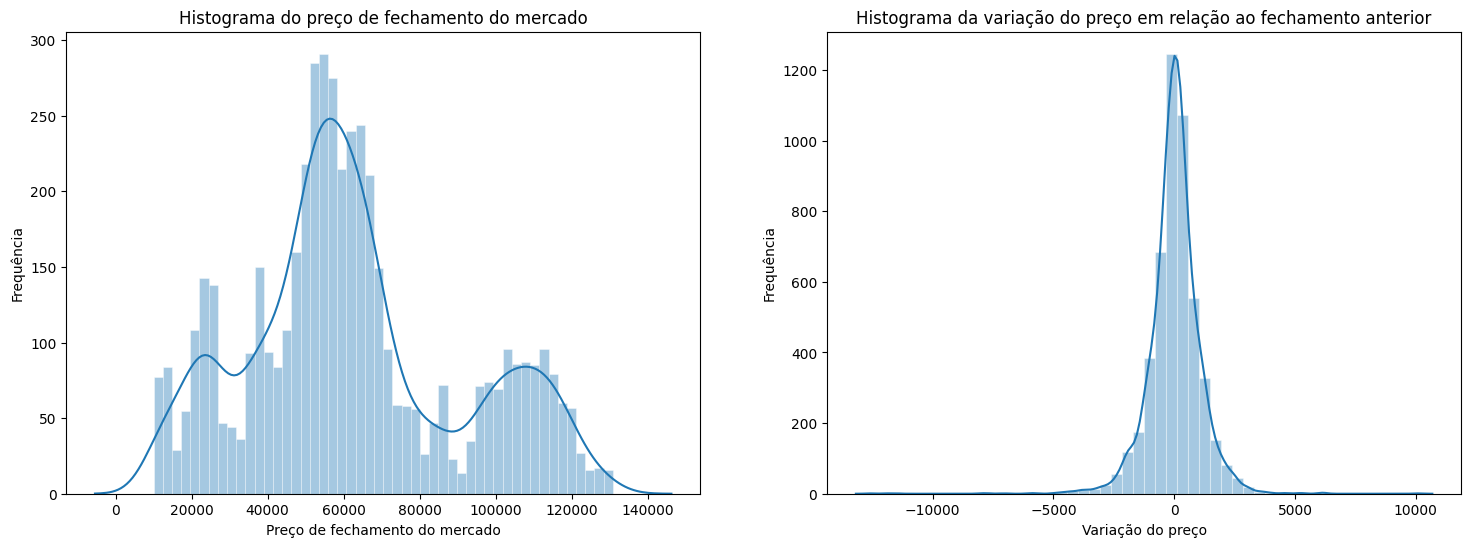

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(18,6))

# Histograma do preço de fechamento do mercado
ax = sns.histplot(
    df['Último'],
    ax=axes[0],
    kde=True, kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
    bins=50,
)
ax.set_title('Histograma do preço de fechamento do mercado')
ax.set_ylabel('Frequência')
ax.set_xlabel('Preço de fechamento do mercado')

# Histograma da variação do preço de fechamento do mercado
ax = sns.histplot(
    df['Último'].diff(1),
    ax=axes[1],
    kde=True, kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
    bins=50,
)
ax.set_title('Histograma da variação do preço em relação ao fechamento anterior')
ax.set_ylabel('Frequência')
ax.set_xlabel('Variação do preço')

plt.show()

#### Teste de normalidade

- Hipótese Nula: os dados seguem distribuição normal
- Hipótese Alternativa: os dados não seguem distribuição normal

Nível de confiança: 95%

In [ ]:
alpha = 0.05
k2, p = normaltest(df['Último'])

print('Teste de normalidade sobre o preço do fechamento')
if p < alpha:
    print('A Hipótese Nula pode ser rejeitada, ou seja, Distribuição NÃO é normal')
else:
    print('A hipótese nula não pode ser rejeitada, ou seja, a Distribuição é normal')

Teste de normalidade sobre o preço do fechamento
A Hipótese Nula pode ser rejeitada, ou seja, Distribuição NÃO é normal


In [ ]:
alpha = 0.05
k2, p = normaltest(df['Último'].diff(1))

print('Teste de normalidade sobre a variação do preço em relação ao fechamento anterior')
if p < alpha:
    print('A Hipótese Nula pode ser rejeitada, ou seja, Distribuição NÃO é normal')
else:
    print('A hipótese nula não pode ser rejeitada, ou seja, a Distribuição é normal')

Teste de normalidade sobre a variação do preço em relação ao fechamento anterior
A hipótese nula não pode ser rejeitada, ou seja, a Distribuição é normal


####Boxplot

Iremos analisar a distribuição dos dados separados por dois distintos grupos: altas e baixas. O boxplot nos permitirá visualizar a proporção de altas e quedas estão distrubuido de forma proporcional, garantindo que nosso  modelo terá dados suficientes para prever os dois cenários de forma efetiva. O boxplot também é uma excelente ferramenta para identificar outiliers.

In [ ]:
#adicionando label 1 para alta e 0 para queda de acordo com a variação

In [ ]:
condicoes = [(df['Var%'] < 0),
             (df['Var%'] > 0)]
opcoes = ["0","1"]
df['class_num'] = np.select(condicoes, opcoes)
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%,class_num
Data,,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297,1
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002,0
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362,1
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119,0
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076,0
...,...,...,...,...,...,...,...
2023-03-03,103866,103326,104440,103323,13100000.0,0.0052,1
2023-03-06,104700,103865,105171,103170,14280000.0,0.0080,1
2023-03-07,104228,104700,105179,103480,12580000.0,-0.0045,0


In [ ]:
condicoes = [(df['Var%'] < 0),
             (df['Var%'] == 0),
             (df['Var%'] > 0)]
opcoes = ["Baixa","Nulo","Alta"]
df['class_name'] = np.select(condicoes, opcoes)
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%,class_num,class_name
Data,,,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297,1,Alta
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002,0,Baixa
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362,1,Alta
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119,0,Baixa
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076,0,Baixa
...,...,...,...,...,...,...,...,...
2023-03-03,103866,103326,104440,103323,13100000.0,0.0052,1,Alta
2023-03-06,104700,103865,105171,103170,14280000.0,0.0080,1,Alta
2023-03-07,104228,104700,105179,103480,12580000.0,-0.0045,0,Baixa


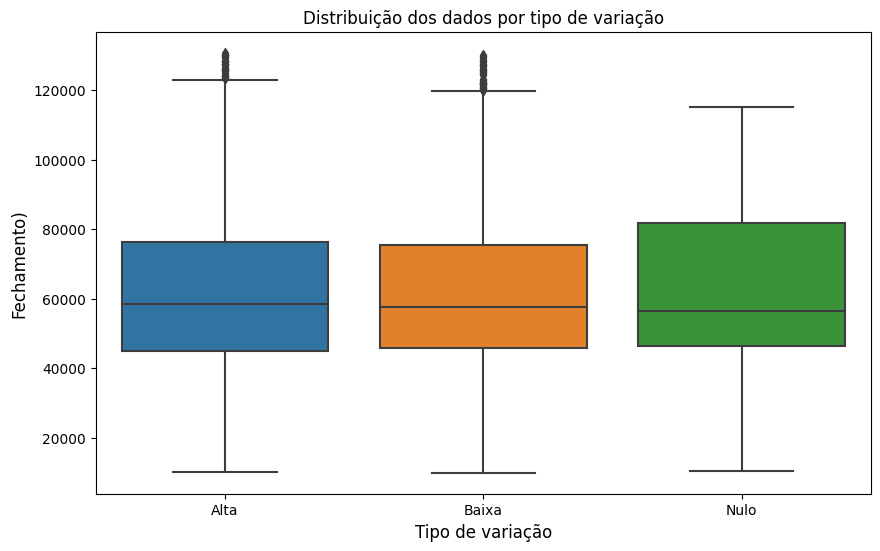

In [ ]:
# definindo o tamanho do plot
fig, ax = plt.subplots(figsize = ( 10, 6 ))

# plotando o gráfico
sns.boxplot(x = 'class_name', y = 'Último', data = df)
ax.set_xlabel( "Tipo de variação" , size = 12 )
ax.set_ylabel( "Fechamento)" , size = 12 )

# definindo o título
plt.title("Distribuição dos dados por tipo de variação");

###Analise de Séries temporais

**Séries temporais** são observações registradas ao longo do tempo e que agregam em seu comportamento as seguintes caracteristicas:

*   **Tendencia (Trend)** :  representa a direção geral para onde sua variavel estará evoluindo no decorrer do tempo.

*   **Sazonalidade (Seasonal)**: são oscilações que podem ocorrer de forma recorrente ou se repetirem em um determinado período de tempo específico

*   **Resíduo (Resid)**:  os dados que não foram identificados ou separados da observação original são também chamado de ruídoou residuo.
*   Item da lista

*   **Estacionariedade**:  quando a média, variância e covariância permanecem constante ao longo da dimensão temporal.

> Fonte: https://maxwellpaparelli.medium.com/time-series-s%C3%A9ries-temporais-com-python-f4e74fd45b0b

Assim, como próximos passos para o projeto, a equipe decidiu  analisar a tendência e sazonalidade da nossa série, bem como iremos identificar se nossa série é estacionária ou não.




####Visualização da série temporal

Plotar a série temporal para analisar o comportamento ao longo do tempo


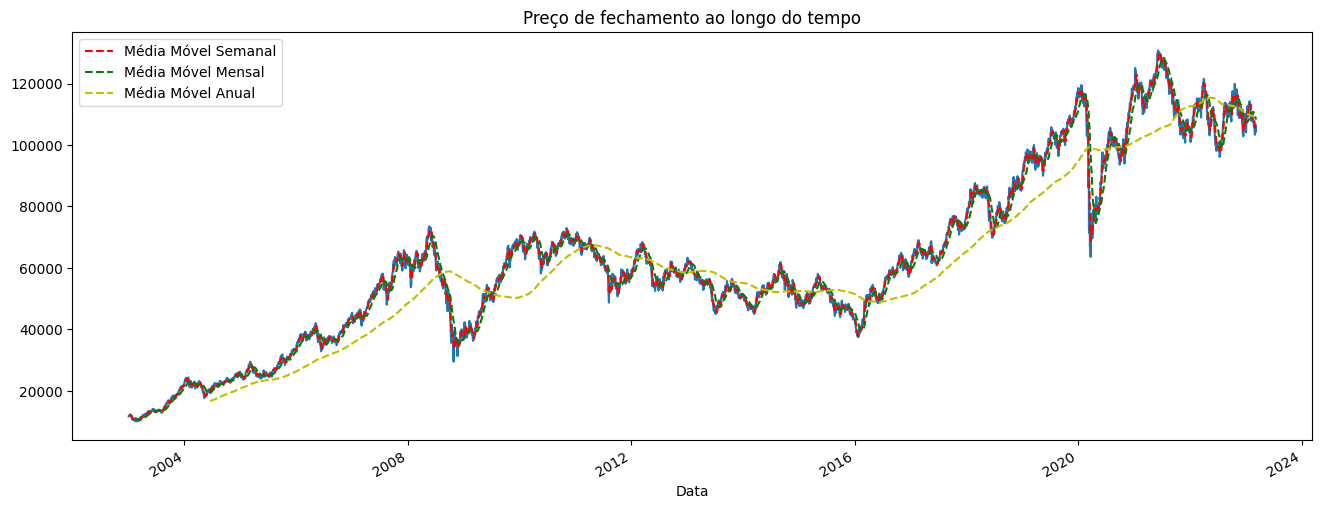

In [ ]:
#Plotar a série temporal para analisar o comportamento ao longo do tempo
plt.figure(figsize = (16, 6))
df['Último'].plot()
df['Último'].rolling(7).mean().plot(color='r', style='--', label='Média Móvel Semanal', legend=True)
df['Último'].rolling(30).mean().plot(color='g', style='--', label='Média Móvel Mensal', legend=True)
df['Último'].rolling(365).mean().plot(color='y', style='--', label='Média Móvel Anual', legend=True)
plt.title("Preço de fechamento ao longo do tempo")
plt.show()

#### Decomposição da série: Tendência, Sazonalidade e resíduo

<Figure size 1600x600 with 0 Axes>

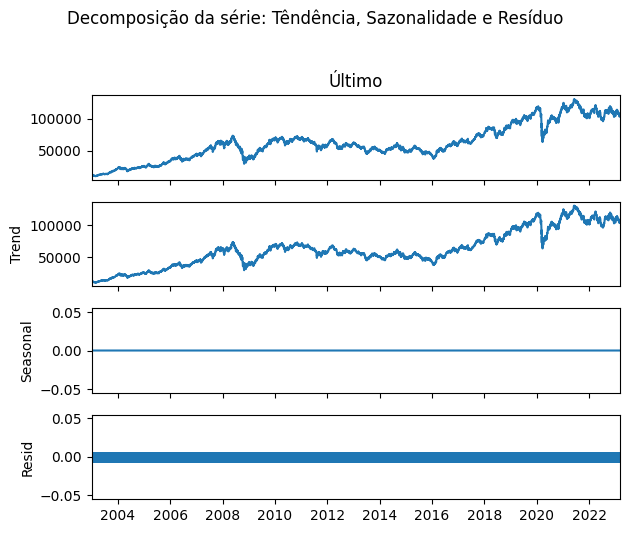

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df["Último"], model = 'additive',period=1)
plt.figure(figsize = (16, 6))
fig= decomposition.plot( ).suptitle('Decomposição da série: Têndência, Sazonalidade e Resíduo',y=1.1)
plt.show()

#### Estacionariedade

> ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:
>
> - Null Hypothesis: The series has a unit root.
> - Alternate Hypothesis: The series has no unit root.
>
> If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

Fonte: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [ ]:
def adf_test(timeseries):
    print("Resultados do teste ADF\n")
    result = adfuller(timeseries)
    print(f"Teste Estatístico: {result[0]}")
    print(f"P-Value: {result[1]}")

    print("\nValores críticos:")
    for key, value in result[4].items():
        print("\t- %s:\t%s" % (key, value))

    print()
    if result[1] < 0.05:
      print('Hipótese nula rejeitada, portanto a série é estacionária.')
    else:
      print('A hipótese nula não foi rejeitada, portanto a série é não estacionária.')


In [ ]:
adf_test(df['Último'])

Resultados do teste ADF

Teste Estatístico: -1.5832810982310113
P-Value: 0.4919863031170957

Valores críticos:
	- 1%:	-3.43166168173001
	- 5%:	-2.8621196211801374
	- 10%:	-2.5670785331097763

A hipótese nula não foi rejeitada, portanto a série é não estacionária.


#### Autocorrelação e Autocorrelação Parcial

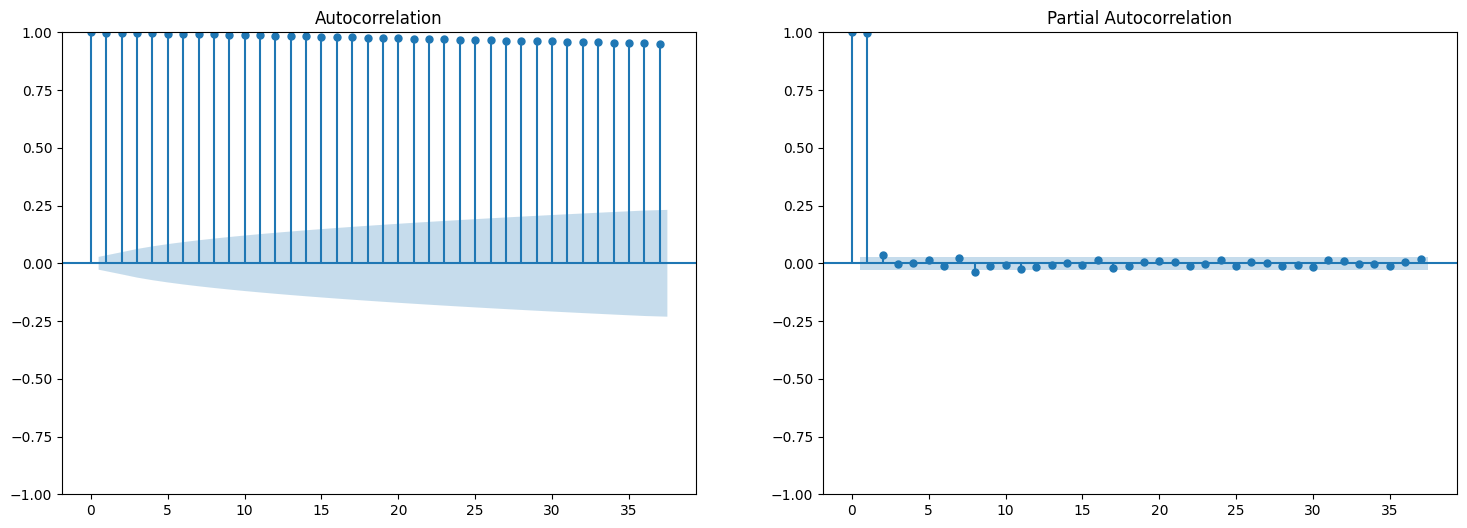

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(18,6))

plot_acf(df['Último'], ax=axes[0])
plot_pacf(df['Último'], ax=axes[1])
plt.show()

## Modelo Preditivo

##Escolhendo os modelos preditivos

Com base nos resultados da analise explorátoria dos dados a equipe selecionou os seguintes modelos para serem testados:

*   Prophet: é recomendado para previsão de dados de séries temporais com base em um modelo aditivo onde tendências não lineares são ajustadas à sazonalidade anual, semanal e diária. O Prophet é robusto em relação à falta de dados e às mudanças na tendência e normalmente lida bem com valores discrepantes.Além de fornecer uma previsão automatizada que poderá ser ajustada manualmente, caso necessário [(Fonte)](https://https://facebook.github.io/prophet/). O q

*   SARIMA: é uma extensão do ARIMA que suporta a modelagem direta do componente sazonal da série.O fato é que no ARIMA é espera dados que não sejam sazonais ou que tenham o componente sazonal removido, por exemplo, ajustados sazonalmente através de métodos como a diferenciação sazonal[(Fonte)](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)







### Naive, SeasonalNaive, SeasonalWindowAverage e AutoARIMA

In [ ]:
!pip install statsforecast=="1.5.0"
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, HistoricAverage

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


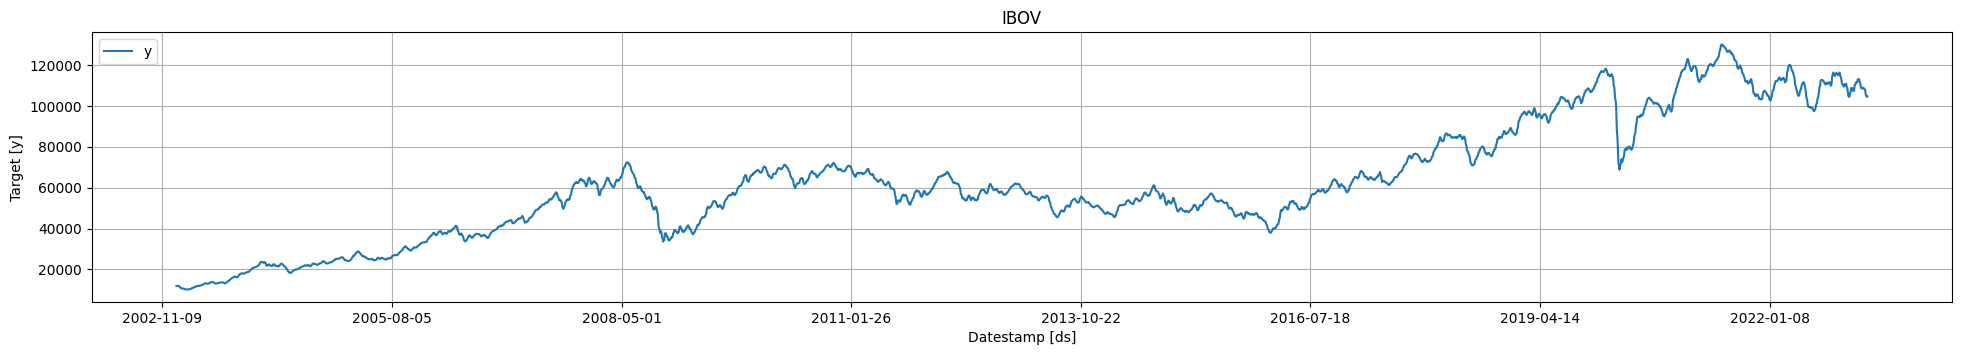

In [ ]:
df_statsforecast = df[['Último']].copy()
# df_statsforecast = df_statsforecast.resample('1D').interpolate()
df_statsforecast['unique_id'] = 'IBOV'
df_statsforecast = df_statsforecast.reset_index()
df_statsforecast = df_statsforecast.rename(columns={'Último':'y', 'Data':'ds'})
df_statsforecast['y'] = df_statsforecast['y'].rolling(7).mean()
df_statsforecast = df_statsforecast.dropna()
StatsForecast.plot(df_statsforecast,engine ='matplotlib')

In [ ]:
df_statsforecast.head(10)

,ds,y,unique_id
6,2003-01-10,11862.857143,IBOV
7,2003-01-13,11935.285714,IBOV
8,2003-01-14,12017.428571,IBOV
9,2003-01-15,12010.428571,IBOV
10,2003-01-16,12021.285714,IBOV
11,2003-01-17,12005.571429,IBOV
12,2003-01-20,11967.857143,IBOV
13,2003-01-21,11852.428571,IBOV
14,2003-01-22,11714.142857,IBOV
15,2003-01-23,11569.428571,IBOV


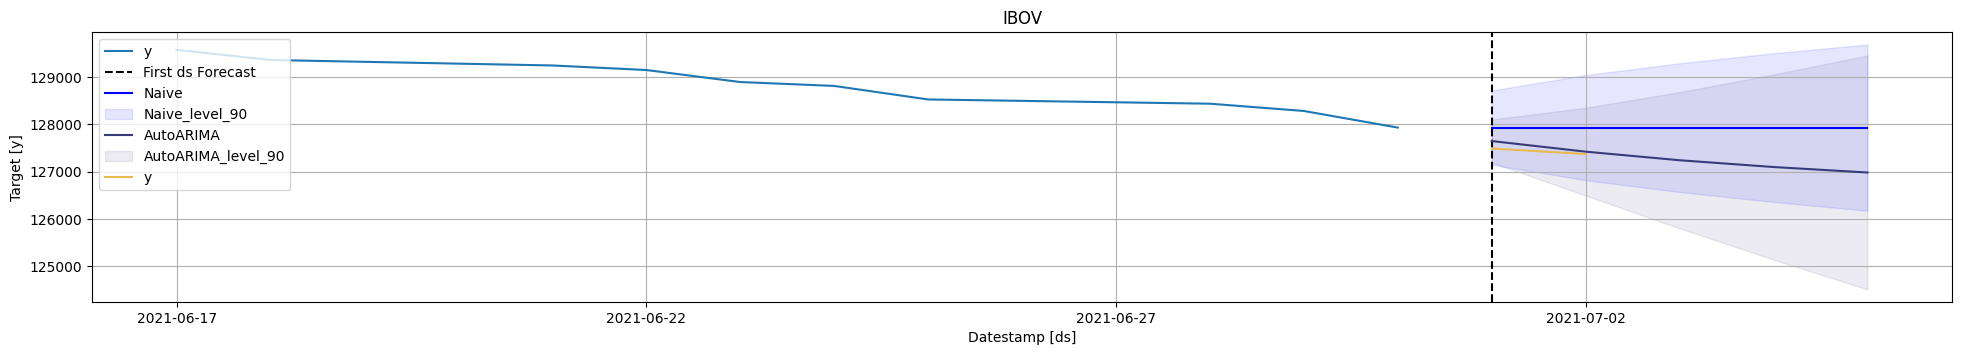

In [ ]:
train_d=365
h=5
Y_df = df_statsforecast[(df_statsforecast['ds'] >= '2021-01-01') & (df_statsforecast['ds'] < '2021-07-01')].copy()
test_df = df_statsforecast[(df_statsforecast['ds'] >= '2021-07-01') & (df_statsforecast['ds'] < '2021-07-06')].copy()
# Y_df['y'] = Y_df['y'].diff()
# Y_df = Y_df.dropna()

sf = StatsForecast(
    # df=Y_df,
    models=[
      Naive(),
      AutoARIMA(season_length=1, trace=False)
    ],
    freq='D',
    n_jobs=-1
)
sf.fit(Y_df)
forecasts_df = sf.predict(h=h, level=[90])
forecasts_df = forecasts_df.reset_index().merge(test_df, on=['ds', 'unique_id'], how='left')
sf.plot(Y_df, forecasts_df, level=[90], max_insample_length=10,engine ='matplotlib', plot_random=False)

In [ ]:
Y_df.dtypes

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object

In [ ]:
forecasts_df.head()

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,IBOV,2021-07-01,127931.859375,127145.250000,128718.468750,127647.343750,127191.664062,128103.015625,127488.857143
1,IBOV,2021-07-02,127931.859375,126819.421875,129044.296875,127422.796875,126493.664062,128351.929688,127373.714286
2,IBOV,2021-07-03,127931.859375,126569.414062,129294.304688,127241.062500,125800.445312,128681.679688,NaN
3,IBOV,2021-07-04,127931.859375,126358.640625,129505.078125,127097.765625,125139.281250,129056.250000,NaN
4,IBOV,2021-07-05,127931.859375,126172.945312,129690.773438,126981.679688,124506.906250,129456.445312,127003.142857


In [ ]:
# h = 7
# teste = df_statsforecast[-h:] # Ultimos dias
# treino = df_statsforecast[:-h] # Todos os dados menos o de teste

# teste

In [ ]:
# frequencia = 'B' # dias uteis
# season_length = 30
# modelos = [
#     Naive(),
#     SeasonalNaive(season_length=season_length),
#     # SeasonalWindowAverage(season_length=season_length, window_size=365),
#     # HistoricAverage(),
#     AutoARIMA(season_length=season_length),
#     AutoARIMA(season_length=season_length, d=1, alias='AutoARIMA_d')
# ]

# sf = StatsForecast(models=modelos, freq=frequencia, n_jobs=-1)

In [ ]:
# sf.fit(treino)

In [ ]:
crossvalidation_df = sf.cross_validation(
    df=df_statsforecast,
    h=h,
    step_size=14,
    n_windows=120
  )
crossvalidation_df

,ds,cutoff,y,Naive,AutoARIMA
unique_id,,,,,
IBOV,2018-08-12,2018-08-11,50199.714844,50481.429688,50435.597656
IBOV,2018-08-13,2018-08-11,49983.000000,50481.429688,50401.480469
IBOV,2018-08-14,2018-08-11,49829.285156,50481.429688,50379.363281
IBOV,2018-08-15,2018-08-11,49530.000000,50481.429688,50365.023438
IBOV,2018-08-16,2018-08-11,49417.285156,50481.429688,50355.730469
...,...,...,...,...,...
IBOV,2023-03-05,2023-03-04,105087.289062,105556.710938,104948.421875
IBOV,2023-03-06,2023-03-04,104674.000000,105556.710938,104518.218750
IBOV,2023-03-07,2023-03-04,104449.710938,105556.710938,104245.390625


<ipython-input-186-c6f65ccea592>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<Axes: xlabel='ds'>

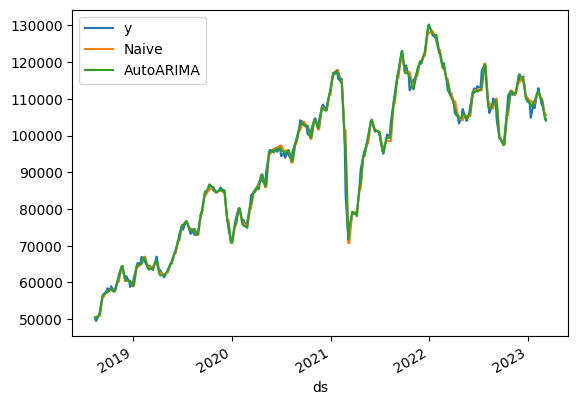

In [ ]:
crossvalidation_df.groupby(['ds']).mean().plot()

In [ ]:
!pip install -q datasetsforecast
from datasetsforecast.losses import mse, mae, rmse, mape


def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [ ]:
evaluation_df = evaluate_cross_validation(crossvalidation_df, mape)
evaluation_df.head()

,Naive,AutoARIMA,best_model
unique_id,,,
IBOV,1.175969,0.803927,AutoARIMA


In [ ]:
mape_AutoARIMA = evaluation_df.loc['IBOV']['AutoARIMA']
mape_AutoARIMA

0.8039265132780807

In [ ]:
# forecast_df = sf.predict(h=h, level=[90])
# # forecast_df = forecast_df.reset_index().merge(teste, on=['ds', 'unique_id'], how='left')
# # forecast_df

# # wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
# # print(f"WMAPE: {wmape1:.2%}")

# model.plot(treino, forecast_df, level=[90], engine ='matplotlib', max_insample_length=h)